# Lab assignment: fraud detection through ensemble methods

<img src="img/fraud.jpg" style="width:600px;">

In this assignment we will use all the skills in ensemble learning we acquired from previous exercises to build a an automated fraud detection system.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

The following code will embed any plots into the notebook instead of generating a new window:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading

The data for this problem is included in the *data* folder, with separate files for training and test data. Each file includes several unidentified explanatory features, together with an "Amount" feature and the target "Class". Fraudulent operations are marked as Class == 1.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Load the training and test data into Pandas DataFrames with names <b>train</b> and <b>test</b>, respectively.
 </td></tr>
</table>

In [10]:
import pandas as pd
train = pd.read_csv("./data/fraud_train.csv", sep = ',')
test = pd.read_csv ("./data/fraud_test.csv", sep = ',')
train.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Perform a brief analysis of the training data to answer the following questions: how many explanatory variables do you have? What is the distribution of classes?
 </td></tr>
</table>

In [11]:
print("train dimension:" ,train.shape)
print("test dimension:" ,test.shape)
X_train, y_train = train.drop(["Class"], axis=1), train["Class"]
X_test, y_test = test.drop(["Class"], axis=1), test["Class"]
print("number of explinatory variables:", X_train.shape[1])
print("number of fraudulent operations:" , len(y_train[y_train==1]))
print("number of not fraudulent operations:", len(y_train[y_train==0]))


train dimension: (5246, 30)
test dimension: (5246, 30)
number of explinatory variables: 29
number of fraudulent operations: 246
number of not fraudulent operations: 5000


## Measuring the performance of a fraud detector

Fraudulent activities are usually prosecuted, therefore fraudsters need to be creative and come up constantly with new ways of performing fraud. Furthermore, frauds are scarce (fortunately), and so we have few positive class patterns available for training. This means the problem is highly unbalanced, which is a problem for training good models, but is also a problem for the model evaluation. 

Consider a dumb model that classifies all data as negative (non-fraud). We can simulate the predictions of this model by creating a predictions vector of all zeros:

In [12]:
dumbpreds = [0] * len(test)

Let's measure the accuracy of this model

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(test["Class"], dumbpreds)

0.9531071292413267

Yo should have obtained a 95% of accuracy, because most of the patterns are indeed negative. But this would be totally useless as a fraud detector! Therefore, we need a better metric.

One that works well for heavily unbalanced problems is the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), or AUC in short. In scikit-learn this metric is readily available, and we can test how this reveals the poor performance of this dumb model

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["Class"], dumbpreds)

0.5

An AUC of 50% means the model is no better than a random guess. We should aim to maximize this metric and attain a 100%, meaning all fraudulent patterns obtain higher scores than non-fraud patterns.

## Unsupervised fraud detector

Since we now we have scarce positive data, it might make sense to start building an unsupervised fraud detector.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Using <b>only the training data</b>, create an Isolation Forest model for anomaly detection. You can use the number of positive patterns in the data to adjust the contamination ratio. Then measure the performance of the model on the test set, in terms of AUC score.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Note the roc_auc_score metric must receive <b>positive class probabilities</b>. It is not possible to obtain these probabilities from an IsolationForest model, but you can make use of its decision_function method to obtain normality scores (average tree depth), which can be negated to obtain positive class scores.
 </td></tr>
</table>

In [70]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [31]:
anomaly_detection = IsolationForest(contamination=len(y_train[y_train==1])/len(y_train))
anomaly_detection.fit(X_train)


IsolationForest(contamination=0.04689287075867327)

In [109]:
preds = anomaly_detection.predict(X_test)
idx_anomalies = np.where(preds == -1)

print("number of anomalies or fraud in test:" ,len(y_test[y_test==1]))
print("number of no anomalies or no fraud in test:" ,len(y_test[y_test==0]))
print("number of good predictions of fraud in test:" ,sum(y_test[idx_anomalies[0]]==1))


number of anomalies or fraud in test: 246
number of no anomalies or no fraud in test: 5000
number of good predictions of fraud in test: 150


In [110]:
test_decision_function = anomaly_detection.decision_function(X_test)
len(test_decision_function[test_decision_function<0])
roc_auc_score(y_test,-test_decision_function)


0.941740650406504

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create a visualization showing the performance of this model over the test data. Suggestion: make use of the <a href=https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>ROC plot portrayed in the scikit-learn docs</a>
 </td></tr>
</table>

In [35]:
from sklearn.metrics import roc_curve, auc

In [63]:

fpr, tpr, _ = roc_curve(y_test, -test_decision_function)
roc_auc = auc(fpr, tpr)
roc_auc   

0.941740650406504

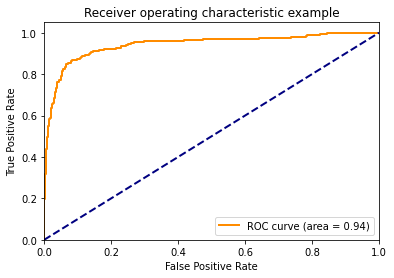

In [60]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Supervised models

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Let's check now whether we can improve the results using supervised models, that is, models that exploit the Class information available in the training data. Try <b>at least five</b> ensemble-based classification models, <b>using only the data in the training set</b>.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
Some suggestions on the scikit-learn models you can use are: Random Forest, Extra Trees, AdaBoost, Gradient Boosting,  Bagging, Voting and Stacking. You can also use an XGBClassifier, also included in this environment.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Bonus points will we awarded for:
     <ul>
         <li>Trying more ensemble strategies beyond the minimum requirement of five.</li>
         <li>Improving the AUC score of your best model as much as possible.</li>
         <li>Trying <a href=https://catboost.ai/>CatBoost</a> and/or <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, other two popular ensemble methods. Note you will need to install these in your environment.</li>
     </ul>
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Now create a visualization showing the performance of your supervised models on the test set, together with the unsupervised model. Has the performance improved after making use of the Class data? Which model obtains the best AUC?
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE